In [ ]:
import pandas as pd 
import numpy as np 
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.metrics import accuracy_score

# Data loading & exploring

In [ ]:
!git clone "https://github.com/muxspace/facial_expressions.git"

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [ ]:
df = pd.read_csv("/content/facial_expressions/data/legend.csv")
df

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral
...,...,...,...
13685,jhamski,SharmilaTagore_80.jpg,HAPPINESS
13686,jhamski,SharmilaTagore_81.jpg,HAPPINESS
13687,jhamski,SharmilaTagore_82.jpg,HAPPINESS
13688,jhamski,SharmilaTagore_83.jpg,HAPPINESS



```
some classes have the same name with diffrent letter cases
```


In [ ]:
labels = df["emotion"].unique()
labels

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt', 'NEUTRAL', 'SADNESS', 'DISGUST', 'FEAR',
       'SURPRISE', 'ANGER', 'HAPPINESS'], dtype=object)

In [ ]:
df['emotion'] = df['emotion'].map(str.lower)

In [ ]:
labels = df["emotion"].unique()
labels

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt'], dtype=object)

In [ ]:
len(df.loc[df.duplicated()])

0

In [ ]:
nclasses = len(list(labels))
nclasses

8

# Data pipeline

### Pipeline

In [ ]:
# index of class in the array is the output 
def One_hot_encoding(label : str):
  arr=np.zeros(nclasses)
  i = list(labels).index(label)
  arr[i] = 1
  return arr

In [ ]:
def Get_emotion(img):
  emotion = df.loc[df['image'] == img, 'emotion'].iloc[0]
  return emotion

In [ ]:
def Suffle_data(x,y):
  temp = list(zip(x, y))
  random.shuffle(temp)
  x, y = zip(*temp)
  # X and y come out as tuples, and so must be converted to np arrays
  x, y = np.asarray(x), np.asarray(y)
  return x,y

In [ ]:
def Pipeline_input(imgs_dir):
  x , y = [] ,[] 
  dir_list = os.listdir(imgs_dir)
  for img in dir_list:
    
    if(df["image"].str.contains(img).any()): # check if img has label
      x.append(imgs_dir+img)
      y.append(One_hot_encoding(Get_emotion(img)))
    else : pass
  
  x, y = Suffle_data(x,y)
  return x , y


In [ ]:
class Pipeline(tf.keras.utils.Sequence):
  def __init__(self,input_x,labels,resize_shape,batch_size,shuffle=True):
    self.x = input_x  # pipeline input 
    self.y = labels   # pipeline output
    self.resize_shape = resize_shape
    # The pipeline needs to take ''' batch size ( 8 examples , 16 examples, 32 example, 48 example)
    # and shuffle paremeter [ true - false ] to shuffle or not shuffle the data
    self.batch_size = batch_size  
    self.shuffle    = shuffle 
    self.on_epoch_end()
    
  def __len__(self):
    # This function determines the number of batches
    return int(np.floor(len(self.y) / self.batch_size))

  def __getitem__(self, index):
    # Get the current batch 
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__get_batch(indexes)
    return X,y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.x))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __read_image(self,path):
    ''' a function that reads the image and do resizing changes the color convention'''
    img=cv2.imread(path)
    dim = self.resize_shape[0:2]
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)/255.0 if self.resize_shape[2]==1 else img/255
    img = img.astype('float32')
    img = cv2.resize(img,dim)
    return img
    

  def __get_batch(self, list_IDs_temp):
    '''
    Does the following three main things:
    1- Create two arrays for input and output with correct shapes
    '''
    if( self.resize_shape[2]==1 ):
      X = np.empty((self.batch_size, self.resize_shape[0],self.resize_shape[1]),dtype=np.float32) #working with b&w or ir
    else:
      X = np.empty((self.batch_size, self.resize_shape[0],self.resize_shape[1],self.resize_shape[2]),dtype=np.float32) #working with rgb
    y = np.empty((self.batch_size,nclasses))#number of classes

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Get expression
      if( self.resize_shape[2]==1 ):
        X[i,:,:] = self.__read_image(self.x[ID])
      else:
        X[i,:,:,:] = self.__read_image(self.x[ID])
      # store label
      y[i,]    = self.y[ID]
    
    return X, y

### splt training and testing and validation

In [ ]:
X,Y = Pipeline_input("/content/facial_expressions/images/")

In [ ]:
x_train, y_train = X[:int(.8*len(X))],Y[:int(.8*len(Y))]
x_val  , y_val   = X[int(.8*len(X)):int(9*len(X))],Y[int(.8*len(Y)):int(9*len(Y))]
x_test , y_test  = X[int(.9*len(X)):],Y[int(.9*len(Y)):]

train_generator = Pipeline(input_x= x_train,labels=y_train,resize_shape=(224,224,1),batch_size=16,shuffle=True)
validation_generator = Pipeline(input_x= x_val,labels=y_val,resize_shape=(224,224,1),batch_size=16,shuffle=True)
test_generator = Pipeline(input_x= x_test,labels=y_test,resize_shape=(224,224,1),batch_size=1,shuffle=True)

In [ ]:
print(len(list(X)),len(list(Y)))
print(len(list(x_train)),len(list(y_train)))
print(len(list(x_val))  ,len(list(y_val))  )
print(len(list(x_test)) ,len(list(y_test)) )

13682 13682
10945 10945
2737 2737
1369 1369


# Models

## VGG-16 convolutional neural network

### model desgin & training

In [ ]:
def Create_model(input_shape):
  image_width,image_height = input_shape[0],input_shape[1]
  # input layer
  input_image = tf.keras.layers.Input(shape=(image_width,image_height,1),name='image',dtype="float32")
  # cnn layers 
  cnn_layer_1_1 = tf.keras.layers.Conv2D(
        64,(3, 3),activation="relu",padding="same",strides=1,name="Conv1_1",)(input_image)
  bm_layer_1_1 = tf.keras.layers.BatchNormalization()(cnn_layer_1_1)
  cnn_layer_1_2 = tf.keras.layers.Conv2D(
        64,(3, 3),activation="relu",padding="same",strides=1,name="Conv1_2",)(bm_layer_1_1)
  bm_layer_1_2 = tf.keras.layers.BatchNormalization()(cnn_layer_1_2)
  polling_nn_layer_1 = tf.keras.layers.MaxPooling2D((2, 2),strides=2 , name="pool1")(bm_layer_1_2)
  
  cnn_layer_2_1 = tf.keras.layers.Conv2D(
        128,(3, 3),activation="relu",padding="same",strides=1,name="Conv2_1",)(polling_nn_layer_1)
  bm_layer_2_1 = tf.keras.layers.BatchNormalization()(cnn_layer_2_1)      
  cnn_layer_2_2 = tf.keras.layers.Conv2D(
        128,(3, 3),activation="relu",padding="same",strides=1,name="Conv2_2",)(bm_layer_2_1)
  bm_layer_2_2 = tf.keras.layers.BatchNormalization() (cnn_layer_2_2)
  polling_nn_layer_2 = tf.keras.layers.MaxPooling2D((2, 2),strides=2 , name="pool2")(bm_layer_2_2)

  cnn_layer_3_1 = tf.keras.layers.Conv2D(
        256,(3, 3),activation="relu",padding="same",strides=1,name="Conv3_1",)(polling_nn_layer_2)
  bm_layer_3_1 = tf.keras.layers.BatchNormalization() (cnn_layer_3_1)
  cnn_layer_3_2 = tf.keras.layers.Conv2D(
        256,(3, 3),activation="relu",padding="same",strides=1,name="Conv3_2",)(bm_layer_3_1)
  bm_layer_3_2 = tf.keras.layers.BatchNormalization() (cnn_layer_3_2)
  polling_nn_layer_3 = tf.keras.layers.MaxPooling2D((2, 2),strides=2 , name="pool3")(bm_layer_3_2)
  
  cnn_layer_4_1 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv4_1",)(polling_nn_layer_3)
  bm_layer_4_1= tf.keras.layers.BatchNormalization() (cnn_layer_4_1)
  cnn_layer_4_2 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv4_2",)(bm_layer_4_1)
  bm_layer_4_2 = tf.keras.layers.BatchNormalization() (cnn_layer_4_2)
  cnn_layer_4_3 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv4_3",)(bm_layer_4_2)
  bm_layer_4_3 = tf.keras.layers.BatchNormalization() (cnn_layer_4_3)
  polling_nn_layer_4 = tf.keras.layers.MaxPooling2D((2, 2),strides=2 , name="pool4")(bm_layer_4_3)
 
  cnn_layer_5_1 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv5_1",)(polling_nn_layer_4)
  bm_layer_5_1= tf.keras.layers.BatchNormalization() (cnn_layer_5_1)
  cnn_layer_5_2 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv5_2",)(bm_layer_5_1)
  bm_layer_5_2 = tf.keras.layers.BatchNormalization() (cnn_layer_5_2)
  cnn_layer_5_3 = tf.keras.layers.Conv2D(
        512,(3, 3),activation="relu",padding="same",strides=1,name="Conv5_3",)(bm_layer_5_2)
  bm_layer_5_3 = tf.keras.layers.BatchNormalization() (cnn_layer_5_3)
  polling_nn_layer_5 = tf.keras.layers.MaxPooling2D((2, 2),strides=2 , name="pool5")(bm_layer_5_3)

  # 2 - Flatten layers
  flatten_layer = tf.keras.layers.Flatten()(polling_nn_layer_5)

  # 2 - Fully connected layers
  fc_layer_6 = tf.keras.layers.Dense(128, activation="relu", name="dense6")(flatten_layer)
  # dropout_6  = tf.keras.layers.Dropout(0.2)(fc_layer_6)
  
  fc_layer_7 = tf.keras.layers.Dense(64, activation="relu", name="dense7")(fc_layer_6)
  dropout_7  = tf.keras.layers.Dropout(0.2)(fc_layer_7)
 
  fc_layer_8 = tf.keras.layers.Dense(nclasses, activation="softmax", name="dense8")(dropout_7)

  model = tf.keras.models.Model(
      inputs= input_image, outputs= fc_layer_8, name="VGG16",
  )

  # Optimizer
  opt = tf.keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt, loss = "CategoricalCrossentropy",metrics=["accuracy","AUC"])
  return model

In [ ]:
# Train the model
model = Create_model(input_shape=(224,224))
epochs = 50
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
)

Epoch 1/50
684/684 [==============================] - 183s 249ms/step - loss: 1.2522 - accuracy: 0.6159 - auc: 0.9118 - val_loss: 0.8120 - val_accuracy: 0.7131 - val_auc: 0.9534
Epoch 2/50
684/684 [==============================] - 170s 249ms/step - loss: 0.7928 - accuracy: 0.7475 - auc: 0.9541 - val_loss: 0.6907 - val_accuracy: 0.7756 - val_auc: 0.9645
Epoch 3/50
684/684 [==============================] - 172s 251ms/step - loss: 0.6889 - accuracy: 0.7832 - auc: 0.9639 - val_loss: 1.0245 - val_accuracy: 0.6919 - val_auc: 0.9327
Epoch 4/50
684/684 [==============================] - 172s 252ms/step - loss: 0.6204 - accuracy: 0.8040 - auc: 0.9702 - val_loss: 0.7694 - val_accuracy: 0.7496 - val_auc: 0.9576
Epoch 5/50
684/684 [==============================] - 172s 252ms/step - loss: 0.5811 - accuracy: 0.8167 - auc: 0.9733 - val_loss: 0.6350 - val_accuracy: 0.7961 - val_auc: 0.9728
Epoch 6/50
684/684 [==============================] - 172s 252ms/step - loss: 0.5489 - accuracy: 0.8279 - auc:

KeyboardInterrupt: ignored

### model evaluation

In [ ]:
y_true = np.apply_along_axis(np.argmax,1,y_test)
y_pred = np.apply_along_axis(np.argmax,1,model.predict(test_generator))


1369/1369 [==============================] - 11s 8ms/step


In [ ]:
print(accuracy_score(y_true, y_pred))
print(accuracy_score(y_true, y_pred, normalize=False))

0.43097151205259315
590


In [ ]:
validation_generator = Pipeline(input_x= x_val,labels=y_val,resize_shape=(224,224,1),batch_size=1,shuffle=True)
val_true = np.apply_along_axis(np.argmax,1,y_val)
val_pred = np.apply_along_axis(np.argmax,1,model.predict(validation_generator))
print(accuracy_score(val_true, val_pred))
print(accuracy_score(val_true, val_pred, normalize=False))

2737/2737 [==============================] - 23s 8ms/step
0.4395323346729996
1203


In [ ]:
model.evaluate(test_generator)

1369/1369 [==============================] - 16s 11ms/step - loss: 0.5257 - accuracy: 0.8283 - auc: 0.9783


[0.5256888270378113, 0.8283418416976929, 0.9782510995864868]

In [ ]:
prediction_to_class = {0:'anger',1: 'surprise',2: 'disgust',3: 'fear',4: 'neutral',5: 'happiness',6: 'sadness',7: 'contempt'}

In [ ]:
def __read_image(path):
  ''' a function that reads the image and do resizing changes the color convention'''
  original = img = cv2.imread(path)
  dim = (224,224)
  img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)/255.0
  img = img.astype('float32')
  img = cv2.resize(img,dim)
  return original,img

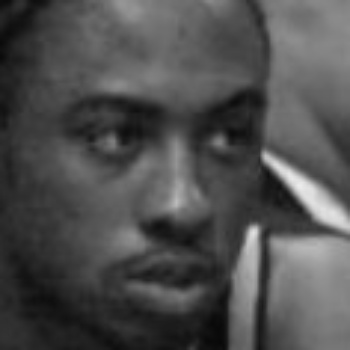

1/1 [==============================] - 0s 226ms/step
prediction = 4
actual label = 4
image description : neutral


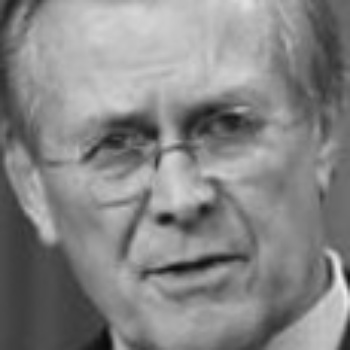

1/1 [==============================] - 0s 21ms/step
prediction = 4
actual label = 4
image description : neutral


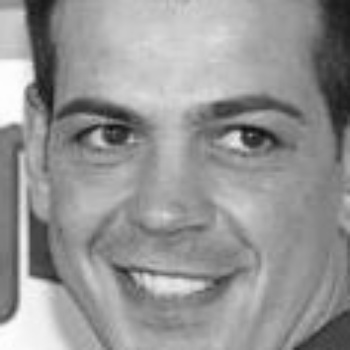

1/1 [==============================] - 0s 17ms/step
prediction = 5
actual label = 5
image description : happiness


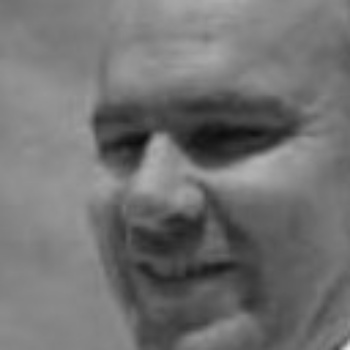

1/1 [==============================] - 0s 17ms/step
prediction = 5
actual label = 5
image description : happiness


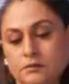

1/1 [==============================] - 0s 17ms/step
prediction = 2
actual label = 2
image description : disgust


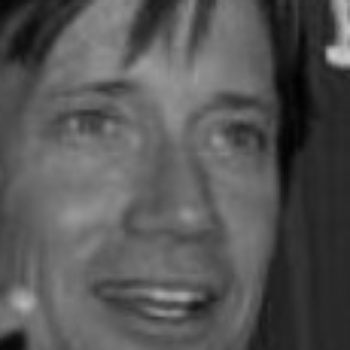

1/1 [==============================] - 0s 17ms/step
prediction = 5
actual label = 5
image description : happiness


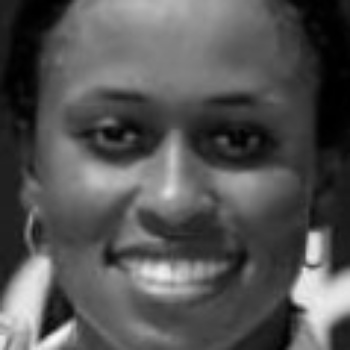

1/1 [==============================] - 0s 15ms/step
prediction = 5
actual label = 5
image description : happiness


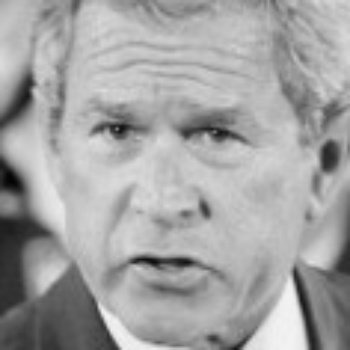

1/1 [==============================] - 0s 18ms/step
prediction = 4
actual label = 4
image description : neutral


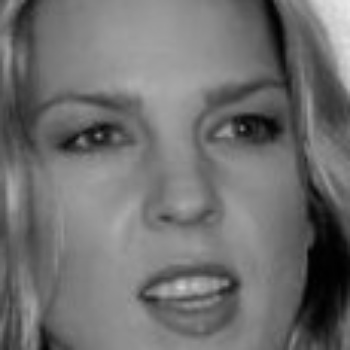

1/1 [==============================] - 0s 16ms/step
prediction = 0
actual label = 4
image description : neutral


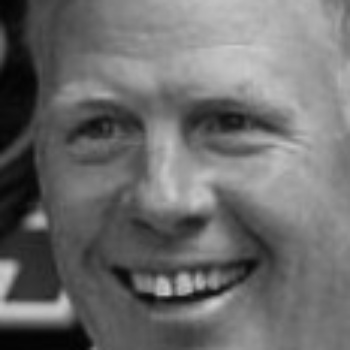

1/1 [==============================] - 0s 16ms/step
prediction = 5
actual label = 5
image description : happiness


In [ ]:
for i in range(10):
  original,img = __read_image(x_test[i])
  actual_label = y_test[i]

  cv2_imshow(original)
  print('prediction = {}'.format(np.argmax(model.predict(img[np.newaxis,:,:]))))
  print('actual label = {}'.format(np.argmax(actual_label)))
  print('image description : {}'.format(prediction_to_class[np.argmax(actual_label)]))

## Mobile Net using (**Keras Applications**)

### model desgin and trainig

In [ ]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False,input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer --  classes
predictions = tf.keras.layers.Dense(nclasses, activation='softmax')(x)

# this is the model we will train
mobile_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
mobile_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy","AUC"])


17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
mobile_train_generator = Pipeline(input_x= x_train,labels=y_train,resize_shape=(224,224,3),batch_size=16,shuffle=True)
mobile_validation_generator = Pipeline(input_x= x_val,labels=y_val,resize_shape=(224,224,3),batch_size=16,shuffle=True)
mobile_test_generator = Pipeline(input_x= x_test,labels=y_test,resize_shape=(224,224,3),batch_size=16,shuffle=True)


In [ ]:
# mobile_model = Create_model(input_shape=(224,224))
epochs = 50
mobile_history = mobile_model.fit(
    mobile_train_generator,
    validation_data=mobile_validation_generator,
    epochs=epochs,
)

Epoch 1/50
684/684 [==============================] - 45s 62ms/step - loss: 0.6794 - accuracy: 0.7626 - auc: 0.9648 - val_loss: 0.6600 - val_accuracy: 0.7416 - val_auc: 0.9665
Epoch 2/50
684/684 [==============================] - 42s 61ms/step - loss: 0.5388 - accuracy: 0.8069 - auc: 0.9769 - val_loss: 0.6458 - val_accuracy: 0.7745 - val_auc: 0.9691
Epoch 3/50
684/684 [==============================] - 41s 59ms/step - loss: 0.4999 - accuracy: 0.8168 - auc: 0.9802 - val_loss: 0.5738 - val_accuracy: 0.7979 - val_auc: 0.9731
Epoch 4/50
684/684 [==============================] - 41s 60ms/step - loss: 0.4512 - accuracy: 0.8324 - auc: 0.9836 - val_loss: 0.6214 - val_accuracy: 0.7993 - val_auc: 0.9701
Epoch 5/50
684/684 [==============================] - 42s 61ms/step - loss: 0.4175 - accuracy: 0.8449 - auc: 0.9856 - val_loss: 0.5792 - val_accuracy: 0.8052 - val_auc: 0.9733
Epoch 6/50
684/684 [==============================] - 41s 60ms/step - loss: 0.3804 - accuracy: 0.8549 - auc: 0.9882 - va

KeyboardInterrupt: ignored

### model evaluation

In [ ]:
mobile_model.evaluate(mobile_test_generator)

85/85 [==============================] - 4s 49ms/step - loss: 1.0035 - accuracy: 0.8125 - auc: 0.9525


[1.0034847259521484, 0.8125, 0.9525488615036011]

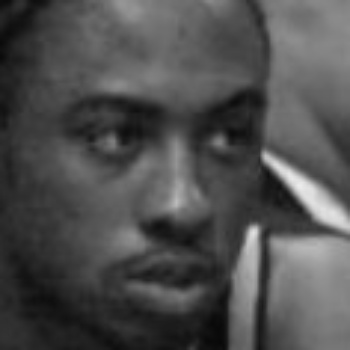

1/1 [==============================] - 1s 612ms/step
prediction = 4
actual label = 4
image description : neutral


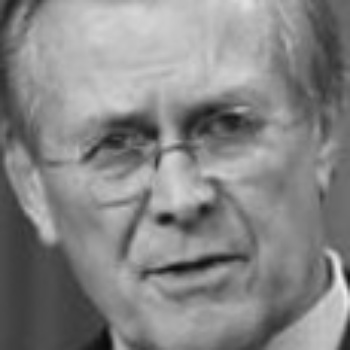

1/1 [==============================] - 0s 20ms/step
prediction = 4
actual label = 4
image description : neutral


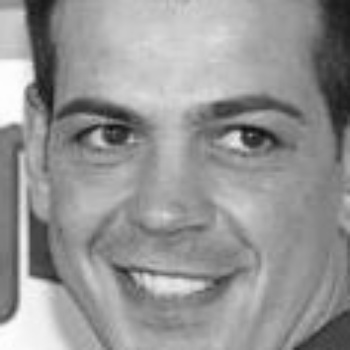

1/1 [==============================] - 0s 17ms/step
prediction = 5
actual label = 5
image description : happiness


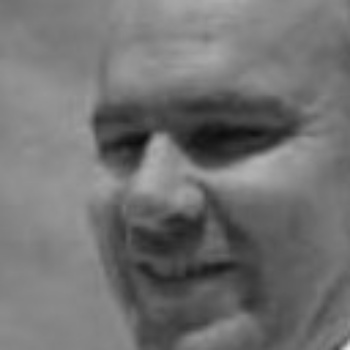

1/1 [==============================] - 0s 18ms/step
prediction = 4
actual label = 5
image description : happiness


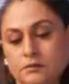

1/1 [==============================] - 0s 17ms/step
prediction = 2
actual label = 2
image description : disgust


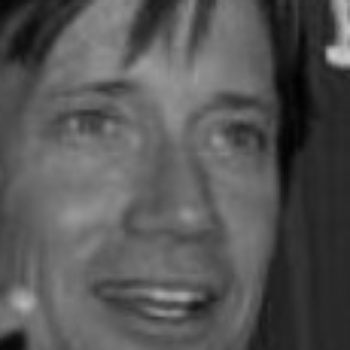

1/1 [==============================] - 0s 18ms/step
prediction = 5
actual label = 5
image description : happiness


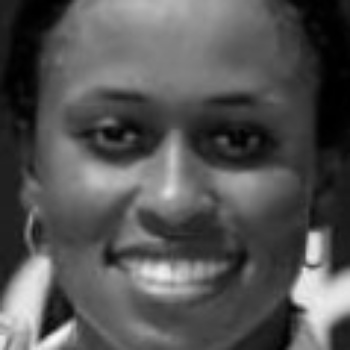

1/1 [==============================] - 0s 17ms/step
prediction = 5
actual label = 5
image description : happiness


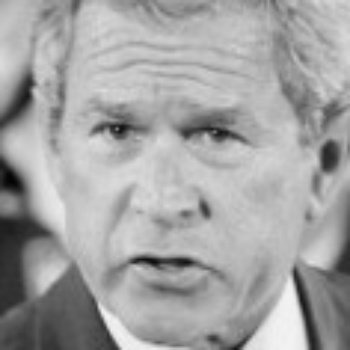

1/1 [==============================] - 0s 21ms/step
prediction = 4
actual label = 4
image description : neutral


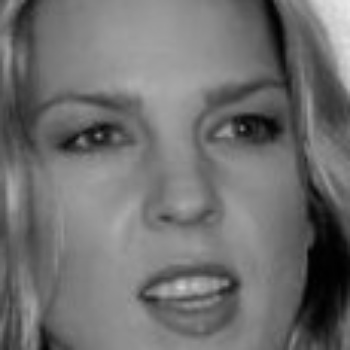

1/1 [==============================] - 0s 19ms/step
prediction = 4
actual label = 4
image description : neutral


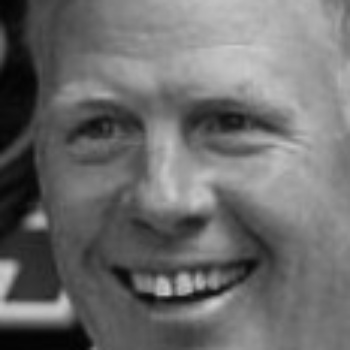

1/1 [==============================] - 0s 20ms/step
prediction = 5
actual label = 5
image description : happiness


In [ ]:
def mob__read_image(path):
  ''' a function that reads the image and do resizing changes the color convention'''
  original = img = cv2.imread(path)
  dim = (224,224)
  img = img.astype('float32')/255.0
  img = cv2.resize(img,dim)
  return original,img

for i in range(10):
  original,img = mob__read_image(x_test[i])
  actual_label = y_test[i]

  cv2_imshow(original)
  print('prediction = {}'.format(np.argmax(mobile_model.predict(img[np.newaxis,:,:,:]))))
  print('actual label = {}'.format(np.argmax(actual_label)))
  print('image description : {}'.format(prediction_to_class[np.argmax(actual_label)]))